Import needed libraries.

In [50]:
import geopandas as gpd
from matplotlib import pyplot as plt
import pandas as pd
import us

Configure `matplotlib`.

In [51]:
%matplotlib inline

Load county shapefile and check out the first couple rows.

In [52]:
counties = gpd.read_file(
    "../source_data/counties_simple/counties_simple.shp"
)

counties.head(2)

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,1477652222,10690952,+41.9158651,-096.7885168,"POLYGON ((246290.041 -328619.667, 246286.510 -..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,680956809,61588406,+46.2946377,-123.4244583,"POLYGON ((-1770686.984 398793.664, -1771124.91..."


Now let's filter to an individual state.

We don't have a column with state name, but we can use **FIPS Codes**.

To start, get the FIPS Code for your desired state.

In [53]:
state_obj = us.states.lookup('AR')

state_obj.fips

print(state_obj.fips)

05


Then, filter to only the counties in that state.

In [54]:
sole_state = counties[ counties['STATEFP'] == state_obj.fips]

sole_state.head(3)

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
16,05,137,00069902,05137,Stone,Stone County,1570579417,7841927,+35.8570011,-092.1404819,"POLYGON ((684573.663 -984338.346, 684531.746 -..."
121,05,113,00069175,05113,Polk,Polk County,2221382790,12372287,+34.4909149,-094.2308841,"POLYGON ((508551.083 -1129377.647, 508544.800 ..."
187,05,063,00069163,05063,Independence,Independence County,1978631568,19593589,+35.7374992,-091.5599423,"POLYGON ((737735.337 -991842.164, 737621.016 -..."


Now plot those counties to check your work.

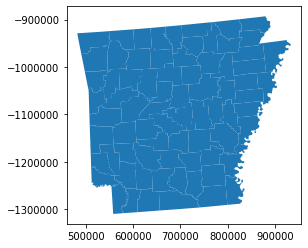

In [55]:
sole_state.plot()

## Joining a shapefile with other data

Load & inspect 2016 Clinton vs. Sanders county-by-county results:

In [56]:
sixteen_margins = pd.read_csv(
    "../source_data/2016-clinton-vs-sanders.csv",
    dtype = {
        "fips_code": str,
        "clinton_percent": float,
    },
)

sixteen_margins.head(3)

,group,fips_code,clinton_votes,sanders_votes,clinton_margin,clinton_percent
0,Alabama,01001,2387,544,1843,0.628796
1,Alabama,01003,5290,2694,2596,0.325150
2,Alabama,01005,2567,222,2345,0.840803


Looks good! Let's merge this data to our shapefile the using the `fips_code` field.

Print out the first few rows of the shapefile to make sure that'll work:

In [57]:
sole_state.head(3)

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
16,05,137,00069902,05137,Stone,Stone County,1570579417,7841927,+35.8570011,-092.1404819,"POLYGON ((684573.663 -984338.346, 684531.746 -..."
121,05,113,00069175,05113,Polk,Polk County,2221382790,12372287,+34.4909149,-094.2308841,"POLYGON ((508551.083 -1129377.647, 508544.800 ..."
187,05,063,00069163,05063,Independence,Independence County,1978631568,19593589,+35.7374992,-091.5599423,"POLYGON ((737735.337 -991842.164, 737621.016 -..."


_**Oops!**_ FIPS Codes are expressed as one field in our Clinton/Sanders data, but as two fields in the shapefile.

In order to merge, we'll need to modify the shapefile data — mashing the two-character `STATEFP` column and the three-character `COUNTYFP` together to create a five-character county FIPS Code.

Thanks to the power of pandas, we can do that with the following line:

In [58]:
counties['fips_code'] = (counties['STATEFP'] + counties['COUNTYFP'])

Let's check that that worked (Hint: scroll all the way to the end of the lines, since this is the most recent field we added):

In [59]:
counties.head(3)

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,fips_code
0,31,039,00835841,31039,Cuming,Cuming County,1477652222,10690952,+41.9158651,-096.7885168,"POLYGON ((246290.041 -328619.667, 246286.510 -...",31039
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,680956809,61588406,+46.2946377,-123.4244583,"POLYGON ((-1770686.984 398793.664, -1771124.91...",53069
2,35,011,00933054,35011,De Baca,De Baca County,6016819484,29089486,+34.3592729,-104.3686961,"POLYGON ((-422754.447 -1210188.449, -422784.93...",35011


Now, let's run the actual merge.

As a note, we'll expand the merge back to the national dataset. (We'll narrow back to just one state again shortly).

In [60]:
joined = counties.merge(
    sixteen_margins,
    on = "fips_code",
    how = "left",
)

In [61]:
joined.head(3)

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,fips_code,group,clinton_votes,sanders_votes,clinton_margin,clinton_percent
0,31,039,00835841,31039,Cuming,Cuming County,1477652222,10690952,+41.9158651,-096.7885168,"POLYGON ((246290.041 -328619.667, 246286.510 -...",31039,Nebraska,34.0,26.0,8.0,0.133333
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,680956809,61588406,+46.2946377,-123.4244583,"POLYGON ((-1770686.984 398793.664, -1771124.91...",53069,Washington,2.0,17.0,-15.0,-0.789474
2,35,011,00933054,35011,De Baca,De Baca County,6016819484,29089486,+34.3592729,-104.3686961,"POLYGON ((-422754.447 -1210188.449, -422784.93...",35011,New Mexico,96.0,114.0,-18.0,-0.085714


Construct an initial plot of our findings.

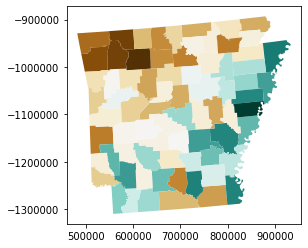

In [62]:
joined_sole_state = joined[joined['STATEFP'] == state_obj.fips]

joined_sole_state.dropna().plot(
    column = "clinton_percent",
    cmap = "BrBG",
)

Make this plot prettier, using the tricks we learned in Part I.

Text(0.5, 1, 'Clinton/Sanders winning margin, 2016')

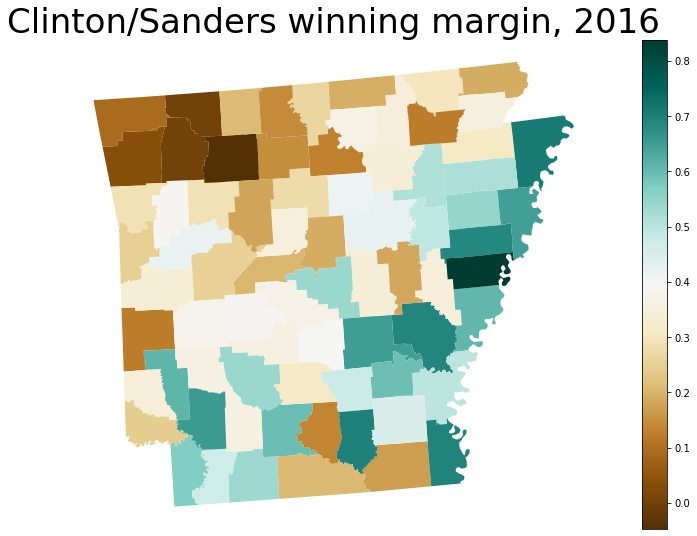

In [63]:
fig, ax = plt.subplots(
    figsize = (16, 9),
)

joined_sole_state.dropna().plot(
    ax = ax,
    column = "clinton_percent",
    cmap = "BrBG",
    legend = True,
)

ax.axis("off")

# The color bar is an axis added to the figure when you do Legend = True.
# Access it by simply iterating through the axes
colorbar = ax.get_figure().get_axes()[0]

# This will return an Array of yticks. Treat it like a list.
yticks = colorbar.get_yticks()

# Using string formatting. Adds commas and removes trailing zeros
colorbar.set_yticklabels(['{0:,.0f}'.format(ytick/1000000000) for ytick in yticks])

# Now, title your axis.
colorbar.set_title("Square Kilometers\n(Millions)")

ax.set_title("Clinton/Sanders winning margin, 2016", fontsize = 34)

Finally, save this map as an image.

In [64]:
fig.savefig(
    f"../output-images/02__clinton-vs-sanders-{state_obj.abbr.lower()}.png", 
    transparent = False,
    bbox_inches = "tight"
)